In [2]:
import os
import requests
import io
from PIL import Image

import fitz
import matplotlib.pyplot as plt
from openai import OpenAI

Page 1: 3 images


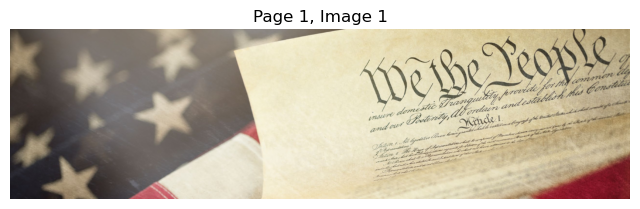

Image 1: 2555x699 pixels, Format: jpeg
BBox x = (-1.1,-1.0), y = (612.0,166.7)


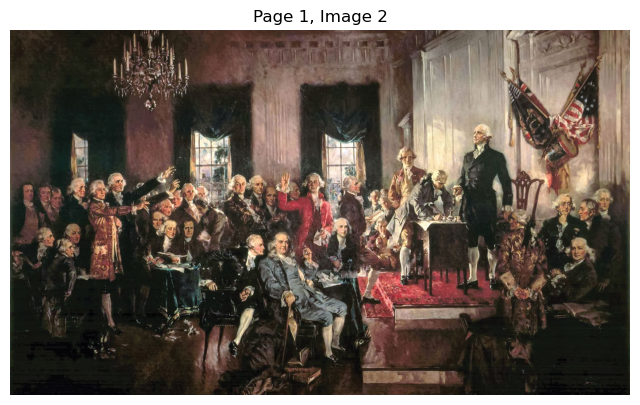

Image 2: 2246x1323 pixels, Format: jpeg
BBox x = (648.5,71.7), y = (1187.5,389.1)


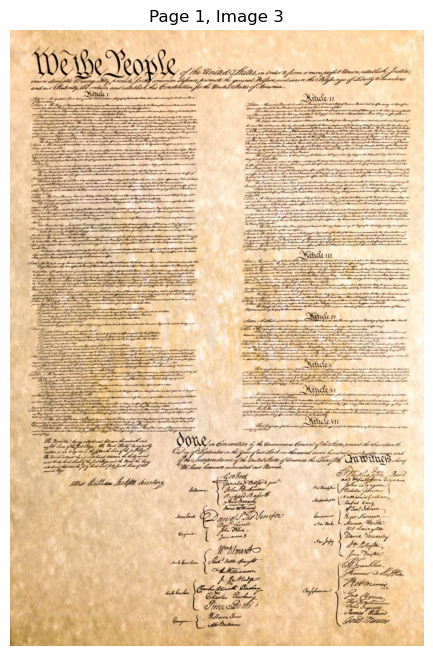

Image 3: 725x1080 pixels, Format: jpeg
BBox x = (647.2,437.9), y = (821.0,697.0)
Page 2: 1 images


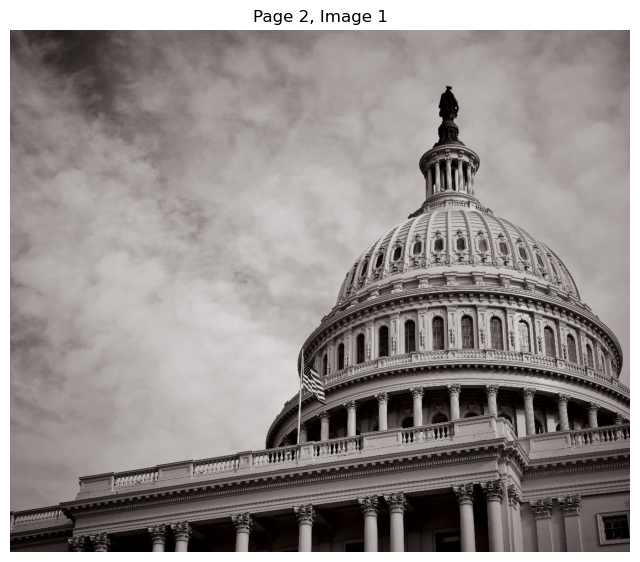

Image 1: 2260x1902 pixels, Format: png
BBox x = (646.9,243.8), y = (1189.1,700.2)
Page 3: 3 images


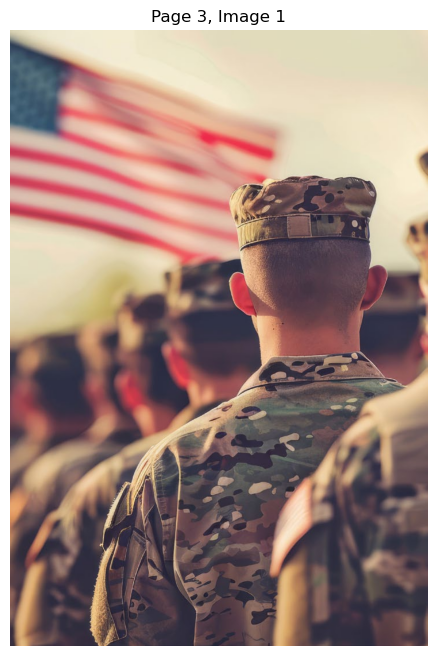

Image 1: 725x1069 pixels, Format: jpeg
BBox x = (647.1,158.2), y = (821.0,414.7)


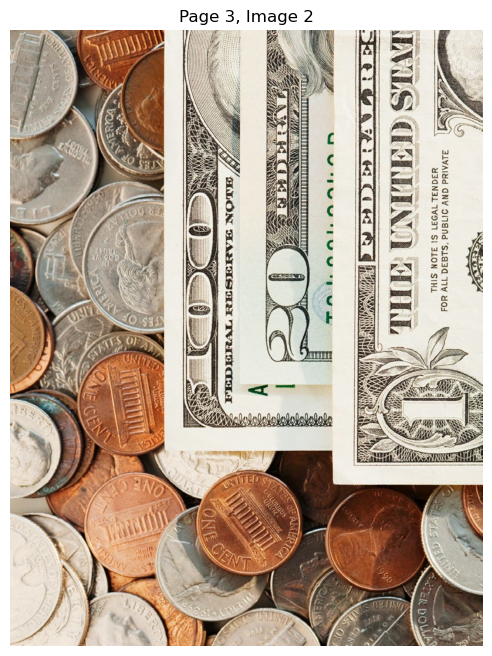

Image 2: 806x1051 pixels, Format: jpeg
BBox x = (637.1,450.1), y = (830.5,702.2)


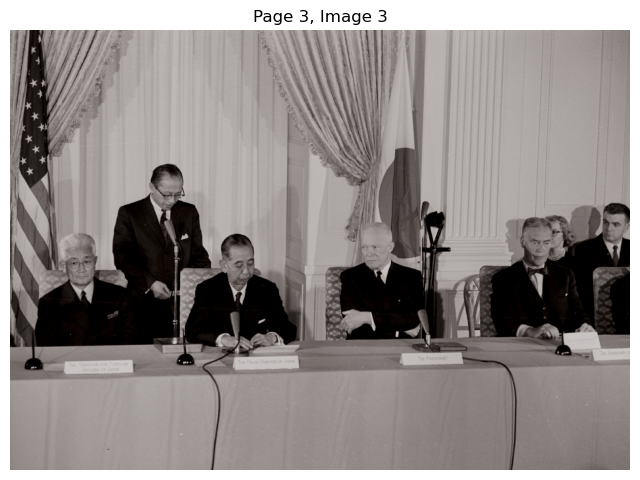

Image 3: 1493x1060 pixels, Format: png
BBox x = (830.8,449.0), y = (1189.0,703.2)
Page 4: 3 images


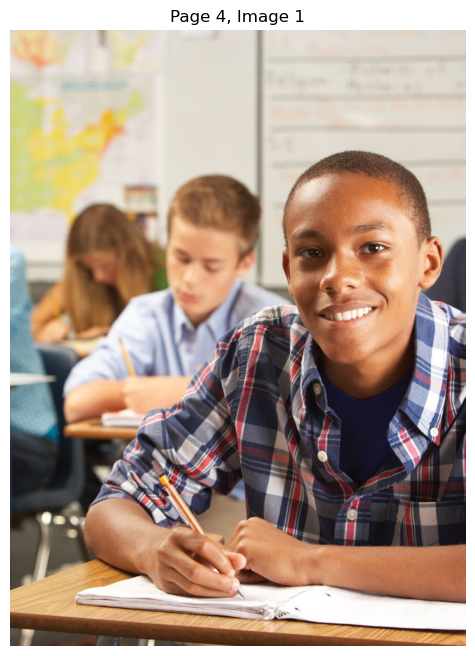

Image 1: 725x980 pixels, Format: jpeg
BBox x = (35.1,452.9), y = (209.1,687.8)


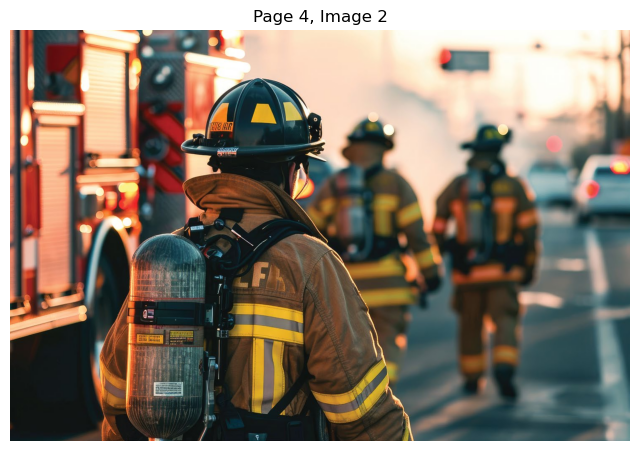

Image 2: 1484x984 pixels, Format: jpeg
BBox x = (219.9,451.8), y = (576.0,687.8)


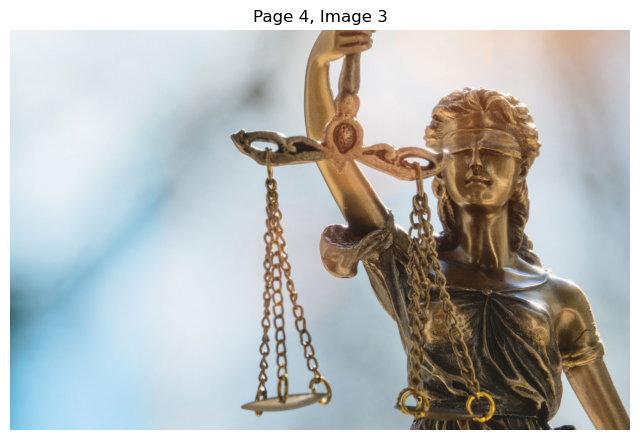

Image 3: 2249x1451 pixels, Format: jpeg
BBox x = (648.6,339.8), y = (1188.1,688.0)
Page 5: 1 images


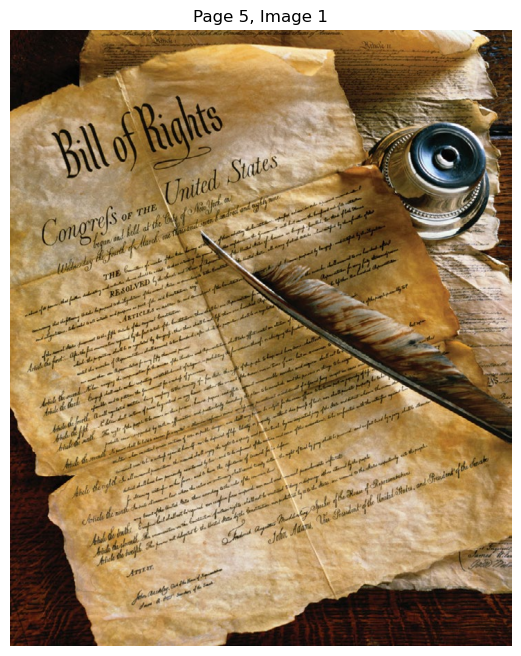

Image 1: 726x892 pixels, Format: jpeg
BBox x = (34.9,473.2), y = (209.0,687.3)


In [12]:
uscis_path = "../data/input-docs/split-pdfs/USCIS Chapter 1.pdf"

doc = fitz.open(uscis_path)

# Iterate through each page
for page_num in range(doc.page_count):
    page = doc.load_page(page_num)
    
    # Get images from the page
    image_list = page.get_images(full=True)
    
    print(f"Page {page_num + 1}: {len(image_list)} images")
    
    # Iterate through images on the page
    for img_index, img_info in enumerate(image_list):
        # Extract image
        xref = img_info[0]  # Get the XREF of the image

        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]
        bbox = page.get_image_bbox(img_info)

        # Load image using PIL
        image = Image.open(io.BytesIO(image_bytes))
        
        # Display image
        plt.figure(figsize=(8, 8))
        plt.title(f"Page {page_num + 1}, Image {img_index + 1}")
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        
        # Print image information
        print(f"Image {img_index + 1}: {image.width}x{image.height} pixels, Format: {base_image['ext']}")

        # Print BBox information
        x0, x1, y0, y1 = bbox
        print(f"BBox x = ({x0:.1f},{x1:.1f}), y = ({y0:.1f},{y1:.1f})")
        
doc.close()

In [10]:
import io
from PIL import Image
import matplotlib.pyplot as plt

uscis_path = "../data/input-docs/split-pdfs/USCIS Chapter 1.pdf"

doc = fitz.open(uscis_path)

# Iterate through each page
for page_num in range(doc.page_count):
    page = doc.load_page(page_num)
    
    # Create a list to store images and their bboxes
    images_with_bbox = []
    
    # Get the page's image blocks
    image_blocks = page.get_image_info()
    
    print(f"Page {page_num + 1}: {len(image_blocks)} images")
    
    # Extract images and their bboxes
    for img_index, img_info in enumerate(image_blocks):
        # Get the image xref
        xref = img_info['xref']
        
        # Get the bbox (in points)
        bbox = img_info['bbox']
        
        # Extract the image
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]
        
        # Load image using PIL
        image = Image.open(io.BytesIO(image_bytes))
        
        # Store image and its bbox
        images_with_bbox.append({
            'image': image,
            'bbox': bbox,
            'format': base_image['ext'],
            'index': img_index
        })
        
        # Display image with bbox information
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 1, 1)
        plt.title(f"Page {page_num + 1}, Image {img_index + 1}")
        plt.imshow(image)
        plt.axis('off')
        
        # Display bbox information
        bbox_info = f"BBox: {bbox}\nSize: {image.width}x{image.height}\nFormat: {base_image['ext']}"
        plt.figtext(0.5, 0.01, bbox_info, ha="center", fontsize=10, 
                    bbox={"facecolor":"white", "alpha":0.7, "pad":5})
        plt.show()
        
        # Print image information
        print(f"Image {img_index + 1}: BBox {bbox}, {image.width}x{image.height} pixels")
        
doc.close()

Page 1: 3 images


KeyError: 0

In [ ]:
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=api_key,
)

completion = client.chat.completions.create(
    extra_body={
        "provider": {
            "sort": "throughput"
        }
    },
    model="anthropic/claude-3.7-sonnet",
    messages=[
        {
          "role": "user",
          "content": [
              {
                  "type": "text",
                  "text": f"""Your Role: iTELL Content Authoring Expert
You are a specialized AI assistant expert in the iTELL framework. Your primary function is to convert source documents into perfectly structured iTELL JSON files.
Source Files for This Task:
The Guide:
{guide_content}

The Content:
{uscis_content}

Reference Output from Another Text:
{reference_json}

Primary Goal:
Your task is to analyze "The Content" file and generate a single, complete, and valid iTELL JSON file. You must adhere strictly and exclusively to the rules defined in "The Guide" file.
Final Output:
Generate the complete, valid JSON in a single code block. Do not include any explanatory text before or after the JSON block.
"""
              }
          ]
        }
    ]

)

print(completion.choices[0].message.content)